# Numerical oracle for the constants

Since validated computations are expensive, we first run some numerical computations to reduce the search space.
Then we will validate the constants.

In [3]:
import Pkg;
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Coding/ExperimentsPseudospectra.jl/notebook`


In [4]:
using Plots

We fix the truncation for the Galerkin approximation.

In [ ]:
K = 256
N = 2 * K + 1

513

We start by defining the dynamic
$$ 
T_c(x) = 2x+c\cdot sinpi(2x)+0.25 \quad \textrm{mod $1$}
$$
with 
$c = \frac{1}{2\pi}-\frac{1}{16}$.

In [8]:
T(x) = 2 * x + (1 / (2 * pi) - 1 / 16) * sin(2 * π * x) + 0.25

T (generic function with 1 method)

Let $S_{r} = \{x+i y \mid -r < |y| < r\}$.

We are interested in finding $\eta$, $\rho$ such that the closure $S_{\eta}$ is contained in $T_{c}(S_{\eta})$.
We are interested in maximizing $\rho-\eta$, since it is the constant appearing in the main error term of our functional analytic treatment, i.e.:
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}.	
$$

For $\rho>0$, we denote by $\mathcal{I}$ the imaginary part of a complex number,
$$
\alpha_u(\rho):=\min_{\theta \in [0,1]}|\mathcal{I}(T_c(x+i\rho))|
$$
where $_u$ stays for upper and 
$$
UR(\rho) := \alpha_u(\rho)-\rho.
$$
We would like to maximize the function $UR$.

In [9]:
α_u(ρ) = minimum(abs.(imag.(T.([x + im * ρ for x in 0:0.001:1]))))

function UR(ρ)
    return α_u(ρ) - ρ
end

UR (generic function with 1 method)

Similarly, we would like to treat the image under the real axis; for $\rho>0$ we define 
$$
\alpha_l(\rho):=\min_{\theta \in [0,1]}|\mathcal{I}(T_c(x-i\rho))|
$$
where $_u$ stays for upper and 
$$
LR(\rho) := \alpha_u(\rho)-\rho.
$$
We would like to maximize the function $UR$.

In [10]:
α_l(ρ) = minimum(abs.(imag.(T.([x - im * ρ for x in 0:0.001:1]))))

function LR(ρ)
    return α_l(ρ) - ρ
end

LR (generic function with 1 method)

We define now 
$$
LR(\rho) = \min\{IR(\rho),OR(\rho)\}
$$
and maximise it.

In [11]:
ER(ρ) = min(LR(ρ), UR(ρ))

ER (generic function with 1 method)

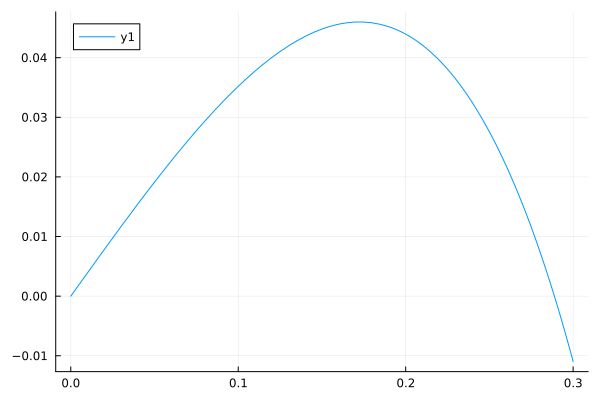

In [12]:
plot(ER, 0, 0.3)

In [34]:
η_rad = 0:0.00001:1

bestrad, indexrad = findmax([ER(η) for η in η_rad])

η = η_rad[indexrad]

0.17244

Therefore, we have found that the value maximizing $\rho-\eta$ is 

In [35]:
η

0.17244

The value of $\rho$ can be now computed as 

In [49]:
num_η = η
num_ρ = min(α_l(num_η), α_u(num_η))
#η_s, ρ_s, ρ_s - η_s

0.21843096214101346

We want to find now an $\alpha$ that minimizes the right hand side of
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}	
$$


In [38]:
function rhs(α, K; η, ρ)
    Dρα = ρ - α
    Dαη = α - η
    coeff_1 = 1 + 2 * (exp(-2 * π * (Dρα))) / (1 - (exp(-2 * π * (Dρα))))
    coeff_2 = exp(-2 * π * K * α) + exp(-2 * π * K * (Dαη))
    return coeff_1 * coeff_2
end

rhs (generic function with 1 method)

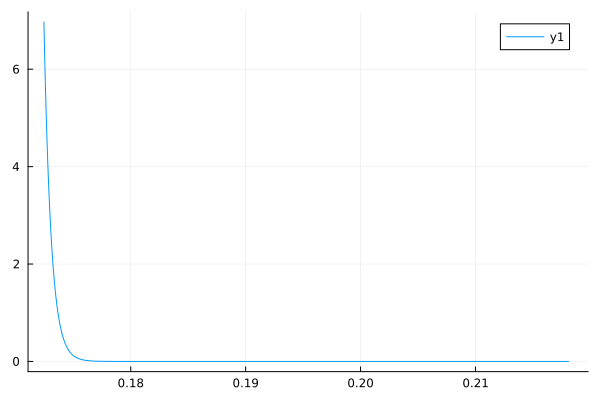

In [39]:
plot(α -> rhs(α, K; η=η_s, ρ=ρ_s), η_s, ρ_s)

In [40]:
α_arr = LinRange(η_s, ρ_s, 10000)
val_min, idx = findmin(map(α -> rhs(α, K; η=η_s, ρ=ρ_s), α_arr))
α_s = α_arr[idx]
val_min, α_s

(1.0377361001148121e-29, 0.2178100220581015)

We compute now the right hand side, supposing $|\mu|>0.3$
$$
||f||_{\infty, \alpha} \leq \left(\frac{1}{|\mu|}\right)^{\frac{\alpha}{\alpha-\eta}} \left( 1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)^{\frac{\alpha}{\alpha-\eta}} ||f||_{\ell^1}.
$$


In [58]:
function weak_strong(μ; η, α, ρ)
    s = α / (α - η)
    coeff_1 = (1 / abs(μ))^s
    coeff_2 = 1 + 2 * (exp(-2 * π * (ρ - α))) / (1 - (exp(-2 * π * (ρ - α))))^s
    return coeff_1 * coeff_2
end

weak_strong (generic function with 1 method)

In [42]:
bws = weak_strong(0.3; η=η_s, α=α_s, ρ=ρ_s)

2.3851136051384806e14

Clearly, the number above is ugly, but the fact that the projection error is small balances out. As a rule of thumb, the superlevel of
the resolvent that contains the eigenvalues is (remark the $sqrt(N)$ to assess the difference between $\ell^1$ and $\ell^2$ pseudospectra): 

In [59]:
(bws * val_min) * sqrt(N)

2.5342796123925414e-12

# Certification of the constants

We certify now the constants involved in the computation above. Due to a change in interface in IntervalArithmetic.jl, we use the 0.20.9 version.

In [24]:
Pkg.add(name = "IntervalArithmetic", version="0.20.9")

   Resolving package versions...
  No Changes to `~/Coding/ExperimentsPseudospectra.jl/notebook/Project.toml`
  No Changes to `~/Coding/ExperimentsPseudospectra.jl/notebook/Manifest-v1.11.toml`


In [25]:
using IntervalArithmetic

To guarantee that the function uses intervals, we declare a new version, we will use the prefix `I`

In [29]:
IT(x) = 2 * x + (1 / (2 * interval(pi)) - 1 / 16) * sinpi(2 * x) + 0.25

IT (generic function with 1 method)

In [ ]:
N = 1048376

Iα_u(η) = minimum(abs.(imag.(T.([interval(i, i+1)/N + im * η for i in 0:1:N-1]))))

function IUR(ρ)
    return α_u(ρ) - ρ
end

IUR (generic function with 1 method)

In [45]:
Iα_l(η) = minimum(abs.(imag.(T.([interval(i, i+1)/N - im * η for i in 0:1:N-1]))))

function ILR(ρ)
    return α_l(ρ) - ρ
end

ILR (generic function with 1 method)

We can now certify the value of $\rho$.

In [52]:
cert_ρ = interval(inf(hull(Iα_u(η), Iα_l(η))))

[0.21843, 0.218431]

Since the image of the $\eta$ strip contains the $cert\_\rho$ strip we also fix $\eta$

In [53]:
cert_η = interval(η)

[0.17244, 0.172441]

The two values are quite near.

In [51]:
num_ρ-cert_ρ

5.551115123125783e-17

We compute now the right hand side, using the $\alpha$ we computed above.

In [57]:
cert_α = interval(α_s)
rhs(cert_α, K; η = cert_η, ρ = cert_ρ)

[1.03773e-29, 1.03774e-29]

In [60]:
weak_strong(interval(3)/10; η = cert_η, α = cert_α, ρ = cert_ρ)

[2.38511e+14, 2.38512e+14]

So, the necessary constants are now all certified. We go forward to certify the enclosure of the eigenvalues.

# Enclosing the eigenvalues

In [86]:
using RigorousInvariantMeasures, BallArithmetic

In [87]:
FourierBasis = RigorousInvariantMeasures.FourierAdjoint(K, 32768)

┌ Warning: This basis breaks the usual interface of the package, i.e., 
│     the dynamic is input as a function instead than a PwMap
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/0z5dS/src/Basis/Fourier/FourierAdjoint.jl:21


FFT on 32768 points restricted to highest frequency 256

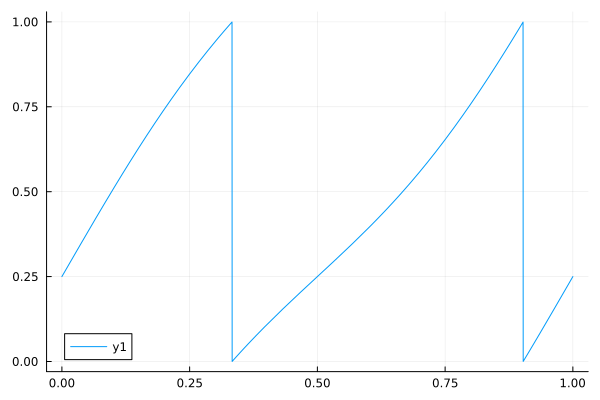

In [ ]:
plot(x -> mod(T(x), 1), 0, 1)

In [89]:
savefig("2xplussome.png")

"/home/isaia/Dropbox/Lavoro/Collaborators/Blumenthal-Nisoli-Taylor-Crush/DraftPseudospectra/current/Julia_notebooks/2xplussome.png"

In [90]:
P = DiscretizedOperator(FourierBasis, T)

┌ Info: Assembling operator, the Newton stopping options are 
│       ϵ = 1.0e-14, max_iter = 100
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/0z5dS/src/GenericAssembler.jl:145
┌ Info: 513
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/0z5dS/src/Basis/Fourier/FourierCommon.jl:74
┌ Info: 256
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/0z5dS/src/Basis/Fourier/FourierCommon.jl:78
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


NonIntegralPreservingDiscretizedOperator{Adjoint{Complex{Interval{Float64}}, Matrix{Complex{Interval{Float64}}}}, Vector{Float64}, Adjoint{Complex{Interval{Float64}}, Vector{Complex{Interval{Float64}}}}}(Complex{Interval{Float64}}[[0.999999, 1.00001] + [-2.21718e-14, 2.21718e-14]im [-2.21718e-14, 2.21718e-14] + [-2.21718e-14, 2.21718e-14]im … [-2.21718e-14, 2.21718e-14] + [-2.21718e-14, 2.21718e-14]im [-2.21718e-14, 2.21718e-14] + [-2.21718e-14, 2.21718e-14]im; [-2.379e-14, 2.37966e-14] + [-0.0447012, -0.0447011]im [-2.3845e-14, 2.37415e-14] + [0.289865, 0.289866]im … [-2.37926e-14, 2.3794e-14] + [-0.000347748, -0.000347747]im [-2.3788e-14, 2.37986e-14] + [0.0045597, 0.00455971]im; … ; [-0.00526224, -0.00526223] + [-2.53461e-14, 2.53504e-14]im [0.000647178, 0.000647179] + [-2.53527e-14, 2.53438e-14]im … [-0.162757, -0.162756] + [-2.52915e-14, 2.5405e-14]im [0.0340126, 0.0340127] + [-2.53506e-14, 2.53459e-14]im; [-2.379e-14, 2.37966e-14] + [0.0447011, 0.0447012]im [-2.37881e-14, 2.37984

In [91]:
import IntervalArithmetic
midI = IntervalArithmetic.mid
radI = IntervalArithmetic.radius

radius (generic function with 4 methods)

In [92]:
midP = midI.(real.(P.L)) + im * midI.(imag.(P.L))

513×513 Matrix{ComplexF64}:
          1.0+0.0im          …           0.0+0.0im
  3.29367e-18-0.0447011im        5.26807e-18+0.0045597im
  -0.00526223-2.12529e-18im      0.000647179+4.3867e-18im
 -1.79373e-18+0.000704313im      2.57289e-18-9.30516e-5im
   9.95789e-5-2.49477e-18im      -1.36658e-5-5.93492e-19im
 -1.39516e-17-1.45163e-5im   …  -1.54205e-17+2.03974e-6im
  -2.15795e-6+1.101e-17im          3.0814e-7+4.20053e-18im
 -7.11563e-18+3.25184e-7im         1.203e-17-4.69793e-8im
    4.9495e-8+9.05596e-18im      -7.21415e-9-1.47238e-17im
  4.97148e-18-7.59141e-9im      -2.46844e-18+1.11421e-9im
             ⋮               ⋱  
  4.97148e-18+7.59141e-9im      -3.20628e-17-4.88868e-8im
    4.9495e-8-9.05596e-18im  …   -3.18785e-7+1.02066e-17im
 -7.11563e-18-3.25184e-7im       9.32865e-18+2.09485e-6im
  -2.15795e-6-1.101e-17im         1.39052e-5-9.3019e-18im
 -1.39516e-17+1.45163e-5im      -9.60057e-18-9.35722e-5im
   9.95789e-5+2.49477e-18im     -0.000642212+1.6698e-17im
 -1.79373e-18-0

In [93]:
radP = sqrt.(radI.(real.(P.L))^2 + radI.(imag.(P.L))^2)

513×513 Matrix{Float64}:
 2.25971e-12  2.25971e-12  2.25971e-12  …  2.25971e-12  2.25971e-12
 2.34088e-12  2.34088e-12  2.34088e-12     2.34088e-12  2.34088e-12
 2.41616e-12  2.41616e-12  2.41616e-12     2.41616e-12  2.41616e-12
 2.49634e-12  2.49634e-12  2.49634e-12     2.49634e-12  2.49634e-12
 2.56019e-12  2.56019e-12  2.5602e-12      2.5602e-12   2.56019e-12
 2.63187e-12  2.63187e-12  2.63187e-12  …  2.63187e-12  2.63187e-12
 2.70973e-12  2.70973e-12  2.70973e-12     2.70973e-12  2.70973e-12
 2.77067e-12  2.77067e-12  2.77067e-12     2.77067e-12  2.77067e-12
 2.82636e-12  2.82636e-12  2.82636e-12     2.82636e-12  2.82636e-12
 2.87368e-12  2.87368e-12  2.87368e-12     2.87368e-12  2.87368e-12
 ⋮                                      ⋱               
 2.87368e-12  2.87368e-12  2.87368e-12     2.87368e-12  2.87368e-12
 2.82636e-12  2.82636e-12  2.82636e-12  …  2.82636e-12  2.82636e-12
 2.77067e-12  2.77067e-12  2.77067e-12     2.77067e-12  2.77067e-12
 2.70973e-12  2.70973e-12  2.70973

In [94]:
BallP = BallMatrix(midP, radP)

513×513 BallMatrix{Float64, ComplexF64, Ball{Float64, ComplexF64}, Matrix{ComplexF64}, Matrix{Float64}}:
                  1.0+0.0im ± 2.25971e-12  …                  0.0+0.0im ± 2.25971e-12
    3.29367e-18-0.0447011im ± 2.34088e-12       5.26807e-18+0.0045597im ± 2.34088e-12
  -0.00526223-2.12529e-18im ± 2.41616e-12      0.000647179+4.3867e-18im ± 2.41616e-12
 -1.79373e-18+0.000704313im ± 2.49634e-12      2.57289e-18-9.30516e-5im ± 2.49634e-12
   9.95789e-5-2.49477e-18im ± 2.56019e-12     -1.36658e-5-5.93492e-19im ± 2.56019e-12
  -1.39516e-17-1.45163e-5im ± 2.63187e-12  …  -1.54205e-17+2.03974e-6im ± 2.63187e-12
    -2.15795e-6+1.101e-17im ± 2.70973e-12       3.0814e-7+4.20053e-18im ± 2.70973e-12
  -7.11563e-18+3.25184e-7im ± 2.77067e-12        1.203e-17-4.69793e-8im ± 2.77067e-12
    4.9495e-8+9.05596e-18im ± 2.82636e-12     -7.21415e-9-1.47238e-17im ± 2.82636e-12
   4.97148e-18-7.59141e-9im ± 2.87368e-12     -2.46844e-18+1.11421e-9im ± 2.87368e-12
                                   

In [95]:
using Pseudospectra

Computing pseudospectra... 100%|████████████████████| Time: 0:00:07


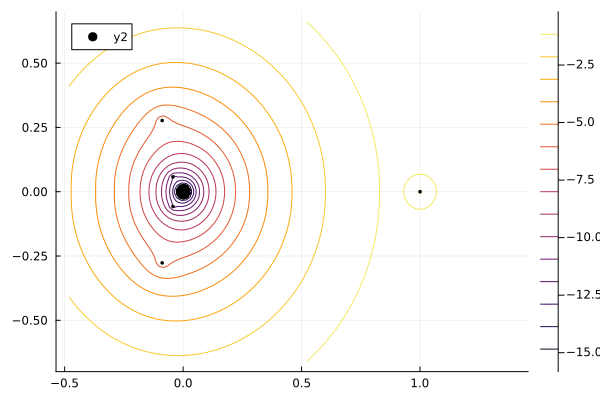

In [96]:
spectralportrait(midP)

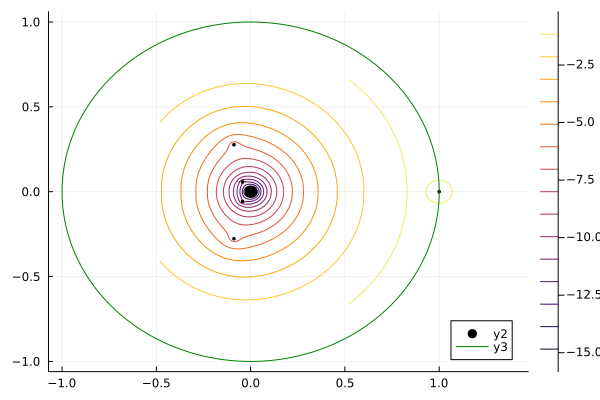

In [ ]:
dθ = 0:0.01:2π
dx, dy = [cos(x) for x in dθ], [sin(x) for x in dθ]
plot!(dx, dy, color=:green)

In [98]:
savefig("Pseudospectra2x.png")

"/home/isaia/Dropbox/Lavoro/Collaborators/Blumenthal-Nisoli-Taylor-Crush/DraftPseudospectra/current/Julia_notebooks/Pseudospectra2x.png"

In [99]:
using LinearAlgebra
abs.(diag(schur(midP).T))

513-element Vector{Float64}:
 0.29064223632113706
 0.2906422363211387
 0.07150393752996896
 0.0715039362339448
 0.024120127934459223
 0.024094789248348267
 0.025136912801644692
 0.024468058828155236
 0.023870523792930157
 0.023532192442507618
 ⋮
 2.4668193575626638e-15
 1.3627328148660481e-15
 1.4818044240903301e-15
 1.4115854962556626e-15
 6.643192107095258e-16
 1.2924857343164929e-15
 1.1642499818992952e-15
 1.6569186223685072e-16
 1.0

With this discretization size we are not going to separate 
things that are separated by less than $0.0025$.
By inspecting the eigenvalues of the Schur matrix, we see that it may be difficult to separate the eigenvalues with norm $0.522...$, that corresponde to a double eigenvalue.
Therefore we resolve to enclose a bigger circle than $0.5$.  

In [100]:
function certify_enclosure(enc, discr_error, weak_strong, errF, errT, norm_Z, norm_Z_inv)
    N = length(enc.points)

    r = Inf
    for i in 1:N
        abs_z = abs(Ball(enc.points[i], enc.radiuses[i]))
        r = min(r, BallArithmetic.sub_down(abs_z.c, abs_z.r))
    end
    δ = BallArithmetic.bound_resolvent(enc, errF, errT, norm_Z, norm_Z_inv)
    left_side = r #BallArithmetic.div_down(1.0, r) # @down
    right_side = BallArithmetic.mul_up(BallArithmetic.mul_up(weak_strong, discr_error), δ) #up
    @info left_side, right_side
    if left_side > right_side
        @info "The enclosure of ", enc.λ, "is certified"
        return true
    else
        return false
    end
end

certify_enclosure (generic function with 1 method)

In [101]:
# A = BallP

# S = schur(Complex{Float64}.(A.c))

# bZ = BallMatrix(S.Z)
# errF = BallArithmetic.svd_bound_L2_opnorm(bZ' * bZ - I)

# bT = BallMatrix(S.T)
# errT = BallArithmetic.svd_bound_L2_opnorm(bZ * bT * bZ' - A)

# sigma_Z = BallArithmetic.svdbox(bZ)

# norm_Z = sigma_Z[1]
# norm_Z_inv = 1.0 / sigma_Z[end]

# eigv = diag(S.T)[[abs(x)>0.0001 for x in diag(S.T)]]

# errF, errT, norm_Z, norm_Z_inv

In [102]:
eigv

UndefVarError: UndefVarError: `eigv` not defined

In [ ]:
lambda0 = eigv[1]
lambda1 = eigv[3]

dt = LinRange(0, 1, 100)

norm_res = [1 / (svd((lambda0 + t * (lambda1 - lambda0)) * I - midP).S[end]) for t in dt]

plot(dt[2:end-1], norm_res[2:end-1])

#E = BallArithmetic._compute_exclusion_circle_level_set_priori(
#            F.T, λ, 2^(-20); rel_pearl_size = 1/128, max_initial_newton = 100)

UndefVarError: UndefVarError: `eigv` not defined

In [ ]:
min_res_norm, i = findmin(norm_res)
@info dt[i], min_res_norm

exclusion_radius = abs(lambda0 + dt[i] * (lambda1 - lambda0))

UndefVarError: UndefVarError: `norm_res` not defined

In [ ]:
bws = weak_strong(exclusion_radius; η=η_s, α=α_s, ρ=ρ_s)

UndefVarError: UndefVarError: `exclusion_radius` not defined

In [106]:
U = UpperTriangular(S.T)

UndefVarError: UndefVarError: `S` not defined

In [107]:
@time svd(U)

UndefVarError: UndefVarError: `U` not defined

In [ ]:
λ = eigv[end]
@info λ
ϵ = 0.000001
target = 2 * ϵ
E1 = BallArithmetic._compute_enclosure_ode(U, λ, ϵ; target=target, max_initial_newton=100, max_steps=1000)

UndefVarError: UndefVarError: `eigv` not defined

In [ ]:
@info 1 / (sqrt(N) * BallArithmetic.bound_resolvent(E1, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E1, val_min, bws * sqrt(N), errF, errT, norm_Z, norm_Z_inv)

UndefVarError: UndefVarError: `E1` not defined

In [ ]:
λ = eigv[1]
# @info λ
ϵ = (1e-9)
target = 1e-8
E2 = BallArithmetic._compute_exclusion_circle_level_set_priori(U,
    λ,
    target; N=1024, max_initial_newton=10)
#E2 = BallArithmetic._certify_circle(U, λ, target, 10)
#E2 = BallArithmetic._compute_enclosure_ode(U, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

UndefVarError: UndefVarError: `eigv` not defined

In [111]:
minimum([x.c for x in E2.bounds])

UndefVarError: UndefVarError: `E2` not defined

In [112]:
plot(E2.points)

UndefVarError: UndefVarError: `E2` not defined

In [ ]:
E2ref = BallArithmetic._refine_enclosure_newton_flow(U, E2, target; rel_err=1 / 8, τ=1)

UndefVarError: UndefVarError: `U` not defined

In [ ]:

E2ref = BallArithmetic._refine_enclosure_newton_flow(U, E2ref, target; rel_err=1 / 1024, τ=1)


UndefVarError: UndefVarError: `U` not defined

In [115]:
plot(E2.points)
plot!(E2ref.points)
scatter!([λ])

UndefVarError: UndefVarError: `E2` not defined

In [ ]:
# we refine to guarantee >ϵ
E2ref = BallArithmetic._refine_enclosure_guarantee(U, E2ref, ϵ)

UndefVarError: UndefVarError: `U` not defined

In [117]:
length(E2ref.points)

UndefVarError: UndefVarError: `E2ref` not defined

In [118]:
minimum([x.c for x in E2ref.bounds])

UndefVarError: UndefVarError: `E2ref` not defined

In [ ]:
minimum([x.c - x.r for x in E2ref.bounds])

UndefVarError: UndefVarError: `E2ref` not defined

In [ ]:
@info 1 / (sqrt(N) * BallArithmetic.bound_resolvent(E2refref, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E2, val_min, bws * sqrt(N), errF, errT, norm_Z, norm_Z_inv)

UndefVarError: UndefVarError: `E2refref` not defined

In [121]:
E2.points

UndefVarError: UndefVarError: `E2` not defined

In [122]:
plot(E2.points)

UndefVarError: UndefVarError: `E2` not defined

In [123]:
# λ = eigvals[3]
# @info λ
# ϵ = 0.00000001
# target = 2 * ϵ
# E3 = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

In [ ]:
@info 1 / (sqrt(N) * BallArithmetic.bound_resolvent(E3, errF, errT, norm_Z, norm_Z_inv))
certify_enclosure(E3, val_min, bws * sqrt(N), errF, errT, norm_Z, norm_Z_inv)

UndefVarError: UndefVarError: `E3` not defined

In [ ]:
E_circ = BallArithmetic._compute_central_exclusion_circle(T, exclusion_radius; max_steps=1000, rel_steps=1024)

UndefVarError: UndefVarError: `exclusion_radius` not defined

In [126]:
BallArithmetic.bound_resolvent(E_circ, errF, errT, norm_Z, norm_Z_inv)

UndefVarError: UndefVarError: `E_circ` not defined

In [127]:
# using Plots

In [128]:
# @recipe function f(::Type{BallArithmetic.Enclosure}, E::BallArithmetic.Enclosure)
#     val_sen = [sen(2*π*x) for x in 0:0.1:1]
#     val_cos = [sen(2*π*x) for x in 0:0.1:1]
    
#     out_x = []
#     out_y = []

#     for (i, z) in enumerate(E.points)
#         append!(out_x, z.+ E.radiuses[i]*val_cos)
#         append!(out_y, z.+ E.radiuses[i]*val_sen)
#     end

#     return out_x, out_y
# end

In [129]:
# λ = eigvals[4]
# @info λ
# ϵ = 0.00001
# target = 2 * ϵ
# E = BallArithmetic._compute_enclosure_ode(F.T, λ, ϵ; target = target,  max_initial_newton = 100, max_steps = 1000)

In [ ]:
1.93 * 10.0^(36 - 47) * 9 / (0.5)

3.4739999999999996e-10

In [131]:
bigger_radius_square(ρ) = minimum(abs.(B.([ρ * exp(im * 2 * π * θ) for θ in 0:0.001:1]))) - ρ^2

bigger_radius_square (generic function with 1 method)

In [132]:
smaller_radius_square(ρ) = 1 / ρ^2 - maximum(abs.(B.([exp(im * 2 * π * θ) / ρ for θ in 0:0.001:1])))

smaller_radius_square (generic function with 1 method)

In [133]:
radius_square(ρ) = min(bigger_radius_square(ρ), smaller_radius_square(ρ))

radius_square (generic function with 1 method)